In [1]:
%matplotlib inline

In [2]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def stft(x, window, step):
    l = len(x)  # input signal length
    n = len(window)  # window length
    m = int(np.ceil(float(l - n + step) / step))

    new_x = np.zeros(n + ((m - 1) * step))
    new_x[:l] = x

    X = np.zeros([m, n], dtype=complex)
    for m in xrange(m):
        start = step * m
        X[m, :] = np.fft.fft(new_x[start: start + n] * window)
    return X

# def stft(x, win, step):
#     framesamp = 1024
#     hopsamp = 512
#     w = np.hanning(framesamp)
#     X = np.array([np.fft.fft(w*x[i:i+framesamp]) 
#                      for i in range(0, len(x)-framesamp, hopsamp)])
#     return X

In [36]:
def istft(X, win, step):
    M, N = X.shape
    l = (M - 1) * step + N
    x = np.zeros(l, dtype=float)
    wsum = np.zeros(l, dtype=float)
    for m in xrange(M):
        start = step * m
        x[start: start + N] = x[start: start + N] + np.fft.ifft(X[m, :]).real * win
        wsum[start: start + N] += win ** 2
    pos = (wsum != 0)
    x[pos] /= wsum[pos]
    return x

# def istft(X, win, step, fs=1024, hop=512):
#     M, N = X.shape
#     l = (M - 1) * step + N
#     x = np.zeros(l, dtype=float)
#     framesamp = X.shape[1]
#     hopsamp = int(hop*fs)
#     for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
#         x[i:i+framesamp] += np.real(np.fft.ifft(X[n]))
#     return x

In [37]:
speech_sampling_rate, speech_data = wavfile.read("trs.wav")
noise_sampling_rate, noise_data = wavfile.read("trn.wav")
x_sampling_rate, x_data = wavfile.read("x_nmf.wav")

In [38]:
fft_size = 1024
window = np.hanning(fft_size)
step = fft_size / 2

In [39]:
speech_spectrogram = stft(speech_data, window, step)
noise_spectrogram = stft(noise_data, window, step)
x_spectrogram = stft(x_data, window, step)

In [40]:
np.abs(speech_spectrogram).T[:513].shape

(513L, 988L)

In [41]:
def nmf(spectrogram, n=1000):
    """
    W = mult(W, (X.H_T)/(W.H.H_T))
    H = mult(H, (W_T.X)/(W_T.W.H))
    :param spectrogram: 
    :return: 
    """
    spectrogram = np.abs(spectrogram).T[:513]
    delta_W = W = np.random.random((spectrogram.shape[0], 30))
    delta_H = H = np.random.random((30, spectrogram.shape[1]))
    alpha = 1.e-20
    for _ in xrange(n):
        W_denominator = np.dot(W, np.dot(H, H.T))+alpha
        W_new = np.multiply(W, np.dot(spectrogram, H.T)/W_denominator)
        
        H_denominator = np.dot(np.dot(W_new.T, W_new), H)+alpha
        H_new = np.multiply(H, np.dot(W_new.T, spectrogram) / H_denominator)
        
        delta_H = H_new - H
        delta_W = W_new - W
        H = H_new
        W = W_new
    print 'delta_W : ', delta_W[0][0]
    print 'W : ', W[0][0]
    print 'delta_H : ', delta_H[0][0]
    print 'H : ', H[0][0]
    return W, H

In [42]:
W_S, H_S = nmf(speech_spectrogram)

delta_W :  0.000428720783819
W :  0.0254452097079
delta_H :  -3.84504872699e-38
H :  2.27343946131e-37


In [43]:
W_N, H_N = nmf(noise_spectrogram)

delta_W :  -2.21558348591
W :  4141.50371514
delta_H :  -2.10081102162e-07
H :  0.000138838210239


In [44]:
W_S.shape

(513L, 30L)

In [45]:
W_N.shape

(513L, 30L)

In [46]:
W = np.hstack((W_S, W_N))
W.shape

(513L, 60L)

In [47]:
X = x_spectrogram.T[:513]
Y = np.abs(X)
# Y = Y.T
Y.shape

(513L, 129L)

In [48]:
H = np.random.random((60, 129))

In [49]:
for _ in range(1000):
#     J = np.dot(np.dot(W, H), H.T) - np.dot(Y, H.T)
#     mult(H, (W.T*X)/(W.T*W*H))
    H_new = np.multiply(H, np.dot(W.T, Y) / np.dot(np.dot(W.T, W), H))
    delta = H - H_new
    H = H_new
#     print J[0][0]
    print delta[0][0]

0.735879702753
0.0535139237962
0.019520579451
0.00976439631246
0.00580354817038
0.00381085249789
0.00267175941755
0.00196843897796
0.00151203139064
0.00120505751074
0.000992719758623
0.000842398063207
0.000733798780742
0.000653819874926
0.000593731770587
0.000547566437739
0.000511163427555
0.000481585217586
0.000456746258679
0.000435168940879
0.000415816897784
0.000397976848748
0.000381172073587
0.00036509750008
0.000349570352497
0.000334492556004
0.000319822335814
0.000305553132989
0.000291698348417
0.00027828067659
0.000265324981776
0.00025285383692
0.000240885001633
0.000229430260094
0.000218495169352
0.00020807938038
0.000198177286839
0.000188778830451
0.000179870348681
0.000171435392735
0.000163455474181
0.000155910719569
0.000148780426305
0.000142043521902
0.000135678933753
0.000129665879278
0.000123984087161
0.000118613960379
0.000113536690993
0.000108734335672
0.000104189859797
9.9887156848e-05
9.58110486867e-05
9.19472714158e-05
8.82824505942e-05
8.48040688845e-05
8.1500428571

In [50]:
sig = np.dot(W_S, H[:30])
sig

array([[  5.18371341e+02,   4.06949986e+02,   5.42220537e+02, ...,
          4.52308364e+00,   2.11862420e+00,   2.82048824e+01],
       [  4.28693691e+02,   3.27696951e+02,   4.43026609e+02, ...,
          3.81700180e+00,   1.49949182e+00,   6.81529388e+01],
       [  3.27432212e+02,   2.49678751e+02,   3.35884835e+02, ...,
          2.35321675e+00,   1.52750959e+00,   8.66413237e+01],
       ..., 
       [  1.68031393e+04,   1.25757962e+04,   1.77204327e+04, ...,
          1.79430007e+01,   1.16644568e+00,   1.03846302e-01],
       [  1.72318652e+04,   1.29062820e+04,   1.81724162e+04, ...,
          1.85762681e+01,   1.35641262e+00,   7.80627798e-16],
       [  1.40054871e+04,   1.04454603e+04,   1.47024076e+04, ...,
          1.33586519e+01,   6.76592839e-01,   3.00135729e+02]])

In [51]:
X_missing = X/Y
X_missing

array([[-1.00000000+0.j        ,  1.00000000+0.j        ,
         1.00000000+0.j        , ...,  1.00000000+0.j        ,
         1.00000000+0.j        ,  1.00000000+0.j        ],
       [ 0.84787273-0.53019981j,  0.39563336-0.91840854j,
        -0.25065658-0.96807607j, ..., -0.99988667+0.01505456j,
        -0.76491395+0.64413248j,  0.33266117-0.94304642j],
       [-0.57974584+0.81479738j, -0.11282724+0.99361462j,
        -0.01639092+0.99986566j, ...,  0.75540574-0.65525733j,
         0.99944170-0.03341079j, -0.71175459+0.70242822j],
       ..., 
       [-0.18230796+0.98324148j,  0.78249307-0.6226593j ,
         0.64737529-0.76217139j, ...,  0.90936764-0.41599338j,
         0.66810084+0.74407074j,  0.91031577-0.41391447j],
       [-0.37400461-0.92742685j, -0.17119145+0.98523778j,
         0.28034974-0.95989792j, ..., -0.18641665-0.98247078j,
        -0.94606135-0.32398753j, -0.95777495+0.28751894j],
       [ 1.00000000+0.j        , -1.00000000+0.j        ,
        -1.00000000+0.j      

In [52]:
sig = sig + X_missing

In [53]:
sig.shape

(513L, 129L)

In [54]:
fft_size_recov = 129
step_recov = fft_size_recov/2
window_recov = np.hanning(fft_size_recov)

In [66]:
recovered = istft(sig, window_recov, step_recov)

(513L, 129L)

In [56]:
wavfile.write('out_wav_q3_final.wav', x_sampling_rate/2, recovered)

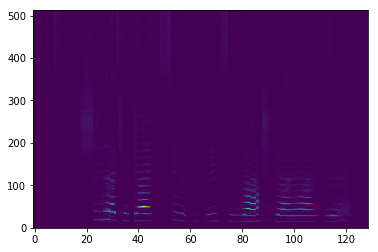

In [57]:
plt.imshow(abs(sig), aspect="auto", origin="lower")

In [58]:
sig_check = sig - x_spectrogram.T[:513]
sig_check

array([[ 26254.59448224     +0.j        ,  -3991.37390093     +0.j        ,
        -19369.14470506     +0.j        , ...,
        -13647.39335897     +0.j        , -26587.47661393     +0.j        ,
          -558.79653331     +0.j        ],
       [-44317.73335850 +27981.25982684j, -14197.58153743 +33718.43989517j,
         22282.67210994 +84348.22584098j, ...,
         30117.34915642   -453.39725681j,  29998.32320486 -25260.26419403j,
         -9584.02710462 +27362.53747227j],
       [ 21712.83658583 -30055.88026386j,  11130.64973190 -95823.42052106j,
          1909.96323310 -96020.64775799j, ...,
        -35464.28622019 +30764.62635451j, -54420.65914129  +1819.3040566j ,
         41237.20335884 -40611.35164591j],
       ..., 
       [ 23741.16243762 -37418.83887488j, -97282.72992632 +87418.57995056j,
        -22592.24849159 +47461.14462386j, ...,
        -11805.07360745  +5408.47993834j,  -3956.35756491  -4407.53499285j,
         -2429.19627551  +1104.58645986j],
       [ 40767.4040

In [59]:
numerator = np.dot(W_S, H[:30])

In [60]:
denominator = np.dot(np.hstack((W_S, W_N)), H)

In [62]:
M_bar = numerator/denominator
M_bar.shape

(513L, 129L)

In [67]:
recovered_mask = istft(M_bar, window_recov, step_recov)

In [68]:
wavfile.write('out_wav_q3_M_bar.wav', x_sampling_rate/2, recovered_mask)